# Danucore - Recruitment Exercise

In this Jupyter notebook, we present a brief exercise related to our work at Danucore. This comprises two questions: the first involves analysis of PV data; and the second involves use of a publicly-available large language model of your choice.

These exercises should take a couple of hours at most, and we would like you to use this exercise to demonstrate your thinking around the problem.

## Q1 - Predicting PV Output

The accompanying CSV file contains daily PV output data and weather data collected from a single location, covering a period of 50 months. You may assume that this data has been collected using sensors installed at the location. The variables included in the data are as follows:

 - `precip`: daily aggregate liquid precipitation;
 - `cloud cover`: percentage of the visible sky that is covered by cloud;
 - `solar radiation`: solar radiation power (in W/m$^2$);
 - `humidity`: relative humidity (expressed as a percentage);
 - `pressure`: sea level atmospheric pressure (in millibars);
 - `UV index`: an indicator for the level of daily UV exposure, based on the amount of short-wave solar radiation and dependent on the cloud cover, type of cloud, altitude and time of year; 0 represents no exposure, 10 represents a high level of exposure;
 - `temp min`: minimum daily temperature
 - `temp max`: maximum daily temperature
 - `solar energy`: daily aggregate energy from the sun (in MJ/m$^2$)

- `PV output`: daily aggregate energy output (in kWh) from a PV array with maximum capacity of 1 kWp
     
Suppose we wish to use the first nine variables (or some subset of these) to predict the daily aggregate solar energy output given by the tenth variable. Suggest and implement a method for doing this: use the first two years of data for any model fitting, and use the final two months to illustrate your model's predictive ability.

If you are using ML methods, these do not need to be fully optimised, though you should demonstrate best practice in any model fitting procedures you implement. All implementation should be carried out in Python and within this notebook.



### Importing Required Libraries


In [164]:
%pip install xgboost

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest, RandomForestRegressor, AdaBoostRegressor
from scipy import stats
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.feature_selection import SelectKBest, mutual_info_regression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import  r2_score, mean_absolute_error, mean_squared_error 
from sklearn.decomposition import PCA


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Zohre\Desktop\danucore\myenv\Scripts\python.exe -m pip install --upgrade pip


### Exploratory Data Analysis

#### Load Dataset


In [3]:
def explore_data():

    """
       Danucore_Recruitment (1).ipynb"this function aims to 
       calculate the shape of dataset along with the count of
       variables and the count of observations
    """
    # Load the csv file
    df = pd.read_csv(file_path)
    shape_of_dataset = df.shape
    print(f'the shape of dataset is:{shape_of_dataset}')
    number_of_observations = df.shape[0] 
    print(f'number of observations:{df.shape[0]}')
    number_of_variables = df.shape[1]
    print(f'number of variables:{df.shape[1]}')

    return df


file_path = './solarPower_50m.csv'
df = explore_data()
df



the shape of dataset is:(793, 11)
number of observations:793
number of variables:11


,Unnamed: 0,precip,cloud cover,solar radiation,humidity,pressure,UV index,temp min,temp max,solar energy,PV output
0,2019-12-01,0.000,72.0,27.9,87.3,1024.4,2.0,0.9,5.4,2.4,0.748
1,2019-12-02,0.120,41.2,NaN,82.0,1032.6,2.0,-1.1,5.8,3.9,1.122
2,2019-12-03,0.000,59.8,42.5,82.6,1027.7,3.0,2.1,8.2,3.7,1.091
3,2019-12-04,0.096,26.2,43.8,90.6,1020.7,3.0,1.0,6.9,3.7,1.060
4,2019-12-05,0.134,85.2,26.5,91.5,1019.4,2.0,1.9,9.7,2.3,0.712
...,...,...,...,...,...,...,...,...,...,...,...
788,2022-01-27,0.605,64.0,23.6,91.7,1030.8,1.0,2.0,10.4,2.1,0.612
789,2022-01-28,0.191,61.8,40.8,95.9,1035.6,2.0,0.6,9.1,3.5,0.401
790,2022-01-29,1.226,77.8,31.0,93.5,1031.9,1.0,3.5,10.2,2.6,0.700
791,2022-01-30,0.124,38.8,53.9,88.9,1031.4,3.0,0.4,8.0,4.7,1.313


- As we can see the dataset has 793 rows and 11 columns with numerical data which are float64. 

for this machine learning task the date column (Unnamed: 0), is not directly useful as a predictive feature, since the goal is to predict  pv output based on weather related factors.so simply we remove the column (Unnamed: 0) from our calculations.

we need the date column for splitting so we need to keep this column.
but in our calculations like handling missing values or calculating correlation matrix actually we dont need this column.
for handling missing values we exclude the column temporarily from our calculations. for correlation matrix also we need to exclude it temporarily. 


### handling missing values

In [4]:
#checking for missing values in each column
def finding_missing_values(df):
    missing_values = df.isnull().sum()
    print("missing values count:\n", missing_values)
missing_values = finding_missing_values(df)
print(missing_values)



missing values count:
 Unnamed: 0          0
precip              0
cloud cover         0
solar radiation    33
humidity            0
pressure            1
UV index            0
temp min            0
temp max            0
solar energy        0
PV output           0
dtype: int64
None


As we can see solar radiation has 33 missing values and pressure has only 1. first we should know about what is the type of missing values , then we can handle them.
first we want to know both numerically and visually how is the missing values status.

#### Visualize Missing Data


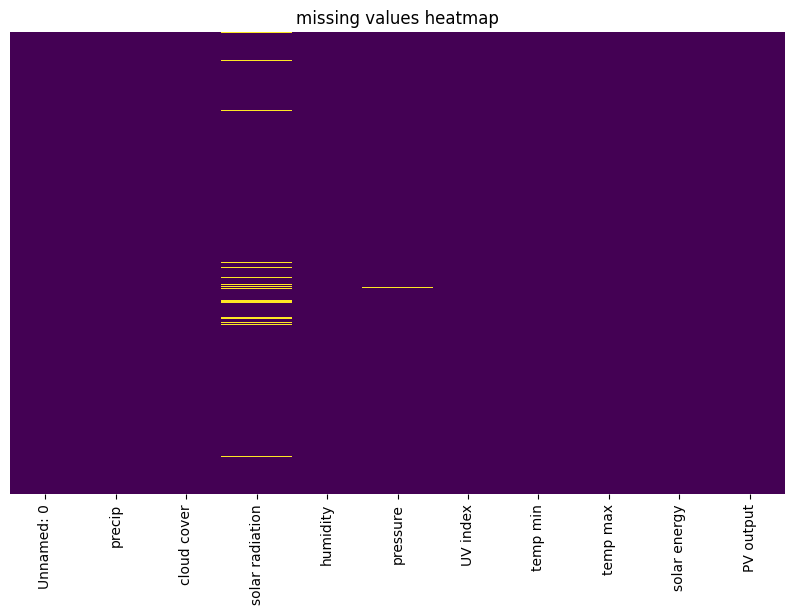

In [5]:
#heatmap to visualize missing values
plt.figure(figsize = (10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("missing values heatmap")
plt.show(
    
)

As we can see missingness in solar radiation is spread in certain areas.

#### Interpret Missing Values

there are three  types of missing values :

MCAR: Missing Completely At Random which means there is no correlation between solar radiation and other variables.

MNAR:Missing Not At Random. missingness would have to be caused by solar radiation itself.for example sensor failure or equipment limitations.

MAR: Missing At Random, which means missing values are influenced by other known variables. in this case missingness correlates strongly with humidity, precipitation, or cloud cover. we should first of all check out this.


pressure only has 1 missing value and this is at random --->MCAR

the most missing data is in solar radiation so we have to carefully handle these missing data.a few missing value in pressure so we can simply fill this using median or forward fill

#### Handle the Missing values in variable pressure

In [6]:
#pressure ---> MCAR
df['pressure'].isnull().sum()
df['pressure'].fillna(df['pressure'].median(), inplace=True)
df['pressure']


C:\Users\Zohre\AppData\Local\Temp\ipykernel_17804\2921121031.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pressure'].fillna(df['pressure'].median(), inplace=True)


0      1024.4
1      1032.6
2      1027.7
3      1020.7
4      1019.4
        ...  
788    1030.8
789    1035.6
790    1031.9
791    1031.4
792    1027.6
Name: pressure, Length: 793, dtype: float64

In [7]:
df['pressure'].isnull().sum()


np.int64(0)

In [8]:
#we first rename Unnamed: 0 column to date because it contains date value
if 'Unnamed: 0' in df.columns:
    df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)


#now we convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# now we ignore this column(date) temporarily because we dont need in our calculation
df_date = df[['date']]
# df_date
df_temporary = df.drop(columns=['date'])
df_temporary

,precip,cloud cover,solar radiation,humidity,pressure,UV index,temp min,temp max,solar energy,PV output
0,0.000,72.0,27.9,87.3,1024.4,2.0,0.9,5.4,2.4,0.748
1,0.120,41.2,NaN,82.0,1032.6,2.0,-1.1,5.8,3.9,1.122
2,0.000,59.8,42.5,82.6,1027.7,3.0,2.1,8.2,3.7,1.091
3,0.096,26.2,43.8,90.6,1020.7,3.0,1.0,6.9,3.7,1.060
4,0.134,85.2,26.5,91.5,1019.4,2.0,1.9,9.7,2.3,0.712
...,...,...,...,...,...,...,...,...,...,...
788,0.605,64.0,23.6,91.7,1030.8,1.0,2.0,10.4,2.1,0.612
789,0.191,61.8,40.8,95.9,1035.6,2.0,0.6,9.1,3.5,0.401
790,1.226,77.8,31.0,93.5,1031.9,1.0,3.5,10.2,2.6,0.700
791,0.124,38.8,53.9,88.9,1031.4,3.0,0.4,8.0,4.7,1.313


#### Handle Missing Values in variable solar radiation

##### Visualize the relationship between missing solar radiation and other variables

C:\Users\Zohre\AppData\Local\Temp\ipykernel_17804\1423919151.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = df_temporary['missing_solar_radiation'], y = df_temporary[feature], ax = axes[row, col], palette=colors)
C:\Users\Zohre\AppData\Local\Temp\ipykernel_17804\1423919151.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(['Not Missing', 'Missing'])
C:\Users\Zohre\AppData\Local\Temp\ipykernel_17804\1423919151.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = df_temporary['missing_solar_radiation'], y = df_temporary[feature], ax = axes[row, col], palette=col

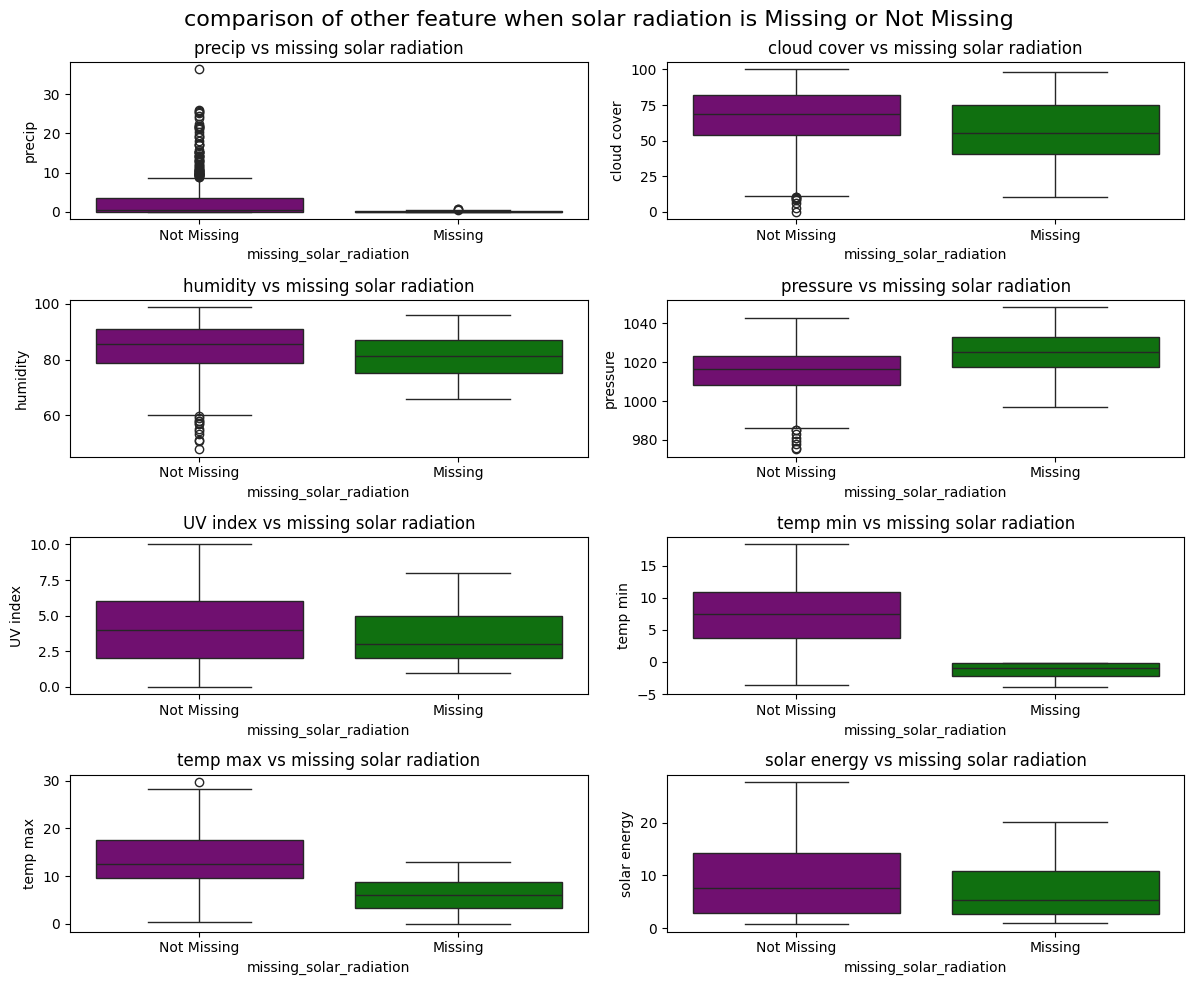

In [9]:
# first we create a new column which shows whether solar radiation is missing or not (1 = missing, 0 = not missing)
df_temporary['missing_solar_radiation'] = df_temporary['solar radiation'].isnull().astype(int)


#feature that we want to compare them with missing solar radiation
check_features = ['precip',	'cloud cover', 'humidity', 'pressure', 'UV index', 'temp min', 'temp max', 'solar energy'] 
colors = {'0': 'purple', '1' : 'green'}


# we draw a boxplot that compares the distribution of these features when solar radiation is missing or not missing
fig, axes = plt.subplots(4, 2, figsize = (12, 10))
fig.suptitle('comparison of other feature when solar radiation is Missing or Not Missing', fontsize=16)
for i, feature in enumerate(check_features):
    row, col = divmod(i, 2)
    sns.boxplot(x = df_temporary['missing_solar_radiation'], y = df_temporary[feature], ax = axes[row, col], palette=colors)
    axes[row,col].set_title(f"{feature} vs missing solar radiation", fontsize=12)
    axes[row, col].set_xticklabels(['Not Missing', 'Missing'])


plt.tight_layout()
plt.show()

interpret the pattern of missing values in solar radiation :
from box plots we simply can see that **cloud cover** is higher when solar radiation is missing which means solar radiation is missing mostly in cloudy days.

also we can see that **precipitation** is slightly higher when solar radiation is missing, which means rainy days might affect on recording solar radiation.

**humidity** also is slightly higher when solar radiation is missing. so we can conclude humid weather also contribute on recording solar radiation.

other variables are lower when solar radiation is missing. which means missingness occurs mostly in cooler and low uv conditions.




since we found out the relationship between missingness and other variables we apply KNN imputation method becuase missingness depends on other features.

what KNN Imputation does is that the algorithm sees the dataset, for each row with missing values it looks at other rows that have similar values for the available features.
it then calculates the distance (Euclidean Distance) between row with missing data and all other rows. then k nearest rows are selected. now the missing values are estimated using mean or median. then weightd average based on how close the neighbors are.
of k-nearest values, and the process is done for all the missing values.

#### Handling missing values in solar radiation with KNN Imputation

In [10]:
features_used_for_imputation = ['precip',	'cloud cover', 'solar radiation', 'humidity', 'pressure', 'UV index', 'temp min', 'temp max', 'solar energy']
# Apply KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)  # initialise knn imputer with 5 nearest neighbors
df_temporary[features_used_for_imputation] = knn_imputer.fit_transform(df_temporary[features_used_for_imputation])

#now check for missing values in variable solar radiation
missing_values_after_imputation = df_temporary['solar radiation'].isnull().sum()
print(f'missing values after imputation are :{missing_values_after_imputation}')

missing values after imputation are :0


In [11]:
# Another check to see if there is missing values
df_temporary.isnull().sum()

precip                     0
cloud cover                0
solar radiation            0
humidity                   0
pressure                   0
UV index                   0
temp min                   0
temp max                   0
solar energy               0
PV output                  0
missing_solar_radiation    0
dtype: int64

In [12]:
df_temporary

,precip,cloud cover,solar radiation,humidity,pressure,UV index,temp min,temp max,solar energy,PV output,missing_solar_radiation
0,0.000,72.0,27.90,87.3,1024.4,2.0,0.9,5.4,2.4,0.748,0
1,0.120,41.2,52.58,82.0,1032.6,2.0,-1.1,5.8,3.9,1.122,1
2,0.000,59.8,42.50,82.6,1027.7,3.0,2.1,8.2,3.7,1.091,0
3,0.096,26.2,43.80,90.6,1020.7,3.0,1.0,6.9,3.7,1.060,0
4,0.134,85.2,26.50,91.5,1019.4,2.0,1.9,9.7,2.3,0.712,0
...,...,...,...,...,...,...,...,...,...,...,...
788,0.605,64.0,23.60,91.7,1030.8,1.0,2.0,10.4,2.1,0.612,0
789,0.191,61.8,40.80,95.9,1035.6,2.0,0.6,9.1,3.5,0.401,0
790,1.226,77.8,31.00,93.5,1031.9,1.0,3.5,10.2,2.6,0.700,0
791,0.124,38.8,53.90,88.9,1031.4,3.0,0.4,8.0,4.7,1.313,0


In [13]:
df_temporary = df_temporary.drop('missing_solar_radiation', axis = 1)
df_temporary

,precip,cloud cover,solar radiation,humidity,pressure,UV index,temp min,temp max,solar energy,PV output
0,0.000,72.0,27.90,87.3,1024.4,2.0,0.9,5.4,2.4,0.748
1,0.120,41.2,52.58,82.0,1032.6,2.0,-1.1,5.8,3.9,1.122
2,0.000,59.8,42.50,82.6,1027.7,3.0,2.1,8.2,3.7,1.091
3,0.096,26.2,43.80,90.6,1020.7,3.0,1.0,6.9,3.7,1.060
4,0.134,85.2,26.50,91.5,1019.4,2.0,1.9,9.7,2.3,0.712
...,...,...,...,...,...,...,...,...,...,...
788,0.605,64.0,23.60,91.7,1030.8,1.0,2.0,10.4,2.1,0.612
789,0.191,61.8,40.80,95.9,1035.6,2.0,0.6,9.1,3.5,0.401
790,1.226,77.8,31.00,93.5,1031.9,1.0,3.5,10.2,2.6,0.700
791,0.124,38.8,53.90,88.9,1031.4,3.0,0.4,8.0,4.7,1.313


#### Count Missing values per Rows

In [14]:
#count missing values in each row
missing_per_row = df_temporary.isnull().sum(axis=1)

#display the number of missing values for the first rows
print(missing_per_row)

0      0
1      0
2      0
3      0
4      0
      ..
788    0
789    0
790    0
791    0
792    0
Length: 793, dtype: int64


### MinMax Ranges with Histogram

ranges:
precip              36.276
cloud cover        100.000
solar radiation    312.500
humidity            51.200
pressure            73.300
UV index            10.000
temp min            22.200
temp max            29.800
solar energy        27.000
PV output            6.795
dtype: float64


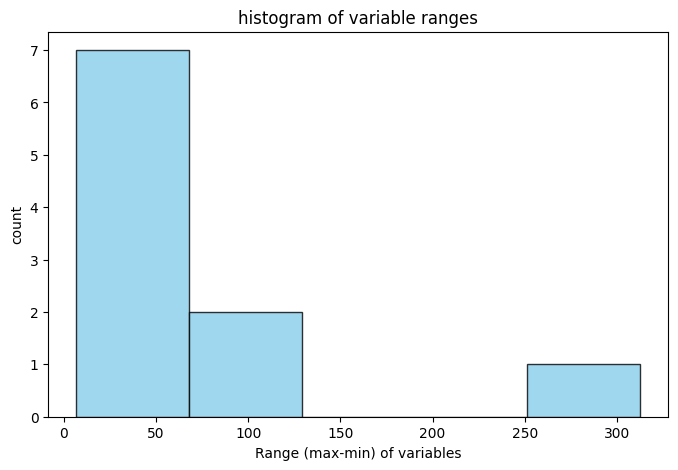

In [15]:
# we want to see the scales of all features in the dataset
def minimax_hist(df_temporary):
    max_values = df_temporary.max()  #calculate maximum values in each variable in dataset
    min_values = df_temporary.min()  # calculate the minimum values for each variable in dataset
    ranges = max_values - min_values
    print(f'ranges:\n{ranges}')
    # print(f'max values:{max_values}')
    # print(f'min values:{min_values}')

    #plotting the histogram of variable ranges
    plt.figure(figsize=(8, 5))
    plt.hist(ranges, bins = 5, alpha = 0.80, color = 'skyblue', edgecolor = 'black')
    plt.xlabel('Range (max-min) of variables')
    plt.ylabel('count')
    plt.title('histogram of variable ranges')
    plt.show()
minimax_hist(df_temporary)


what we can see from this graph is that the highest count of variablesa re in range of (~0 to 50).featues like humidity, uv-index, and pressure.

few variables like temp min and temp max have moderate variations. (~50 to 100)

solar radiation and solar energy has larg range (~300+)

### Pairwise Comparisons including PV output

<Figure size 1000x400 with 0 Axes>

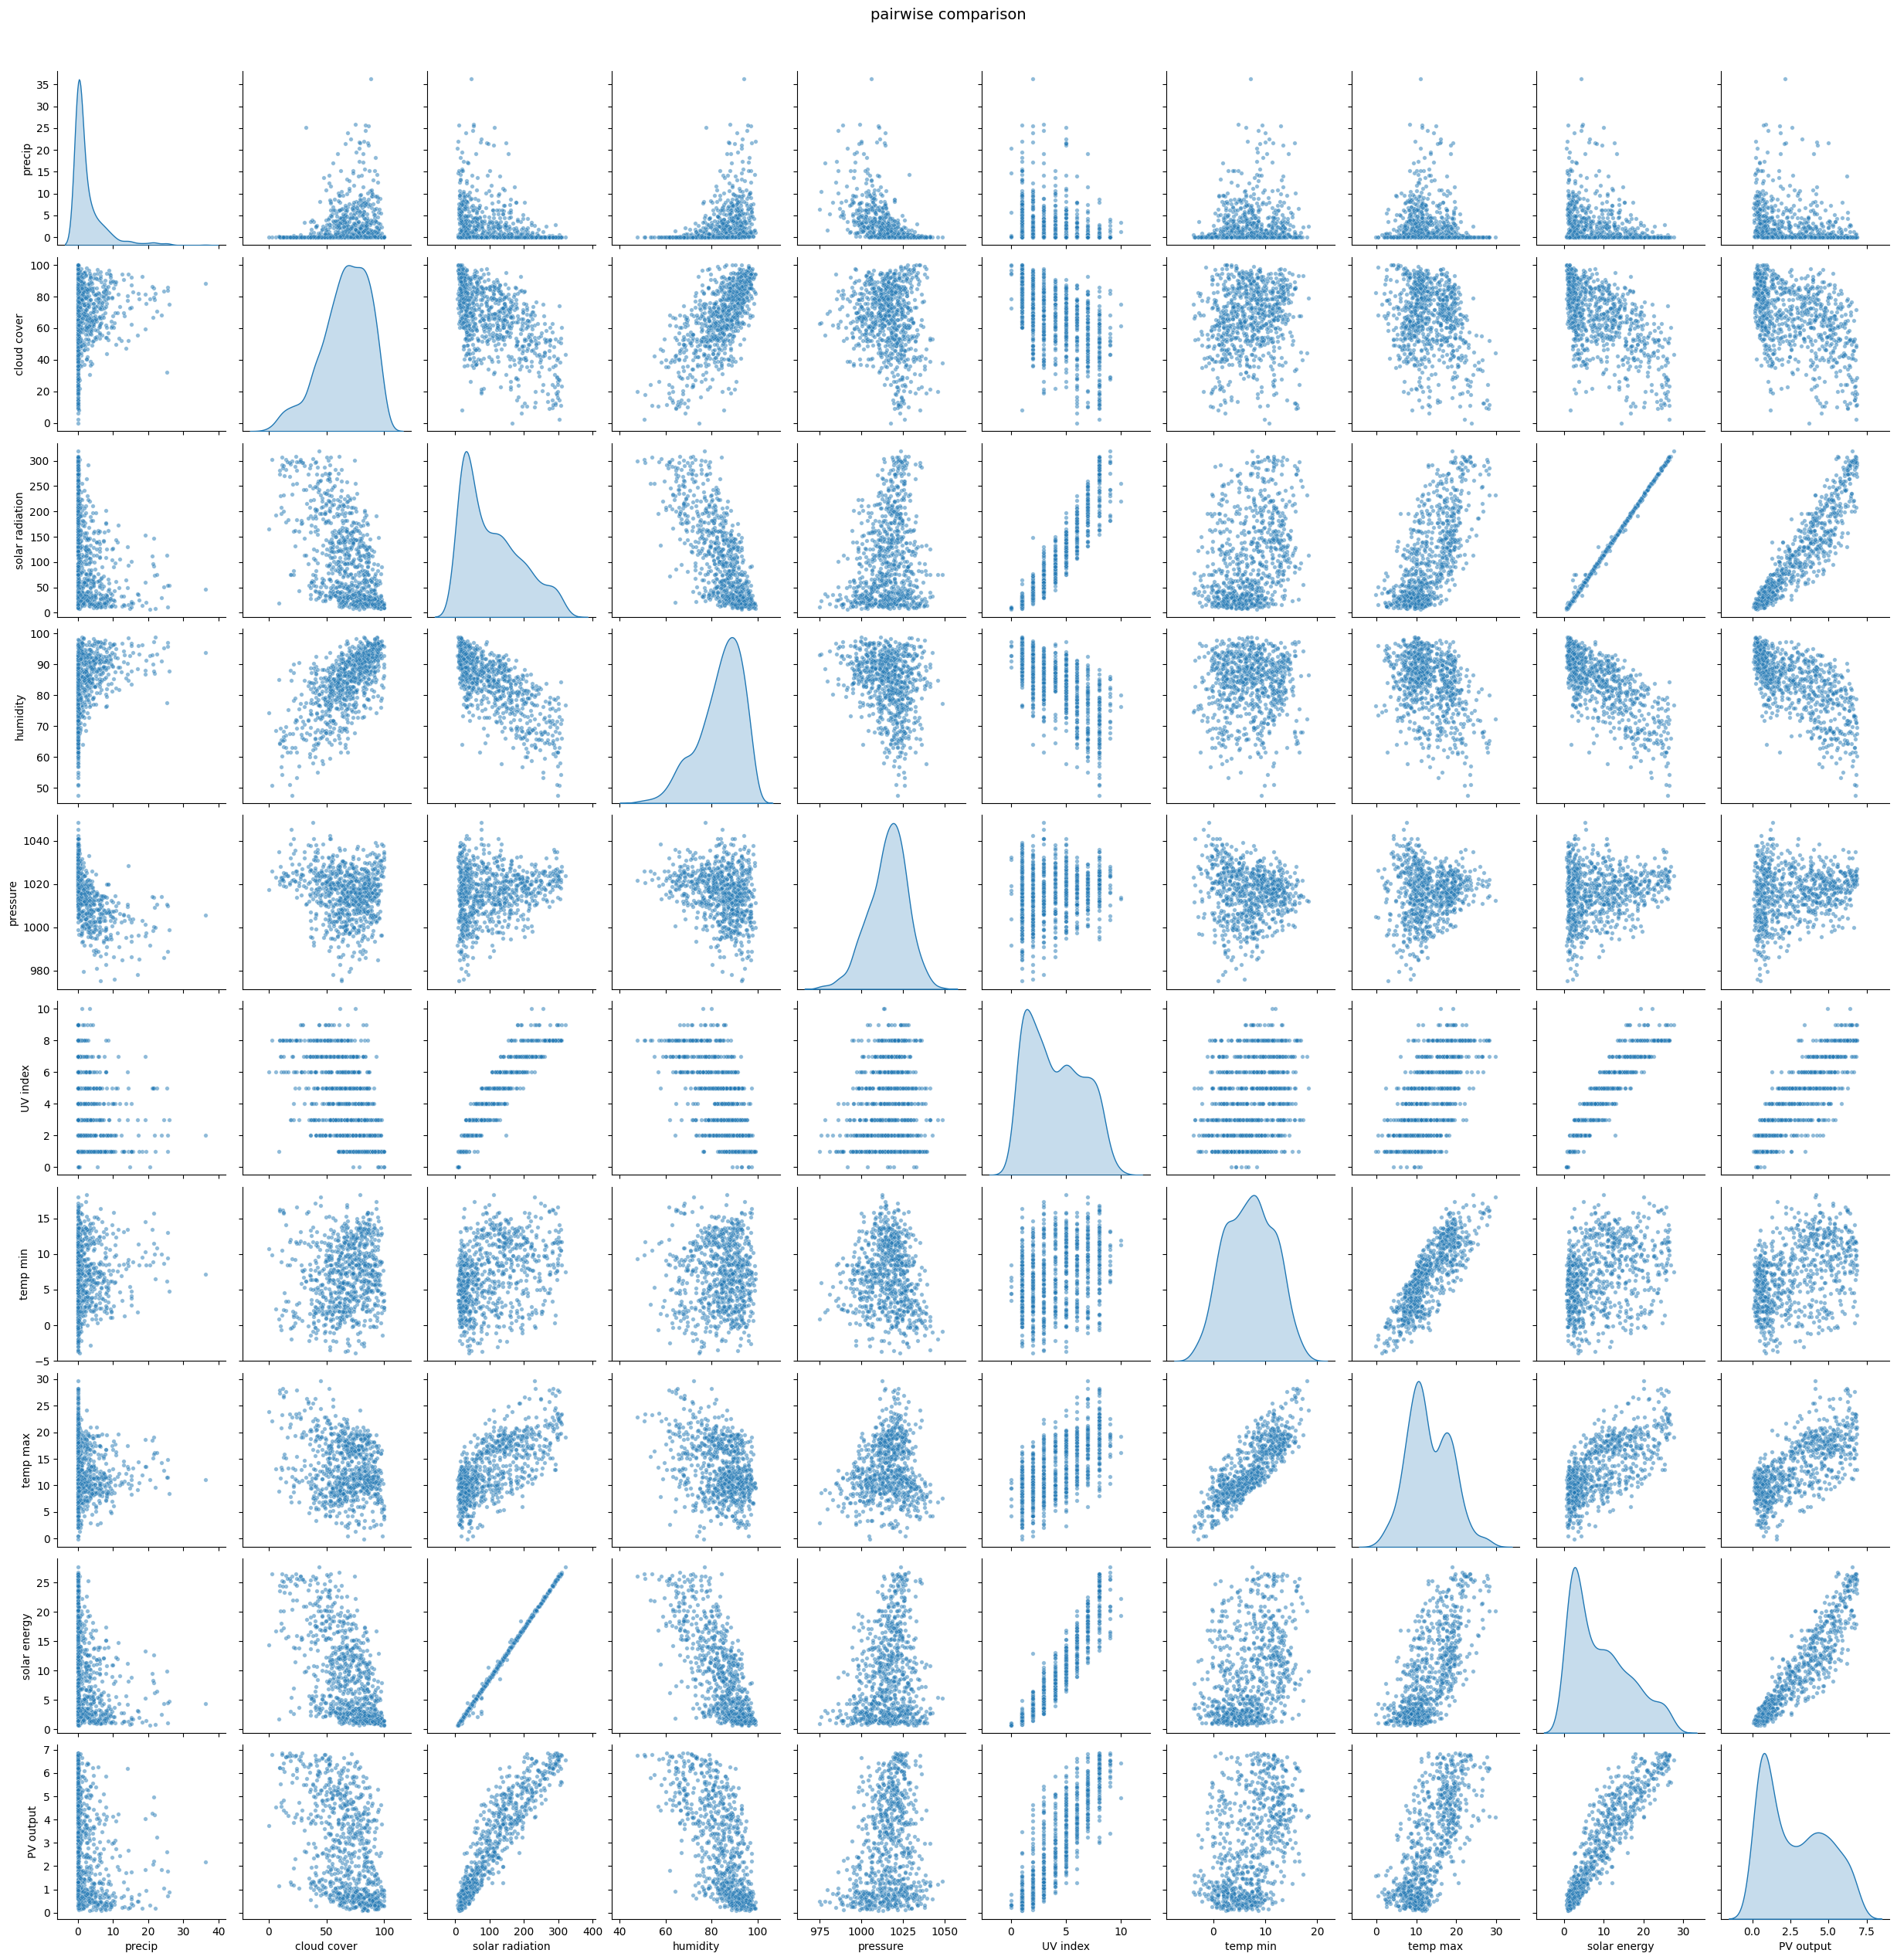

In [16]:
plt.figure(figsize=(10, 4))
sns.pairplot(df_temporary, diag_kind='kde', markers='o', plot_kws={'alpha':0.5, 's':15})
plt.suptitle('pairwise comparison', y=1.02, fontsize=14)
plt.show()

what we get from this graph is:
1- high correlation between solar radiation and solar energy
2- strong positive relationship between pv output/ solar radiation and solar energy
3- negative correlation between cloud cover and pv output. more clouds leads to lower pv output, which makes sense.
4- no clear relationship between precipitation and pv output
5- high correlation between temp min and temp max and also high relation between output and temp max

#### Calculating Correlation Matrix

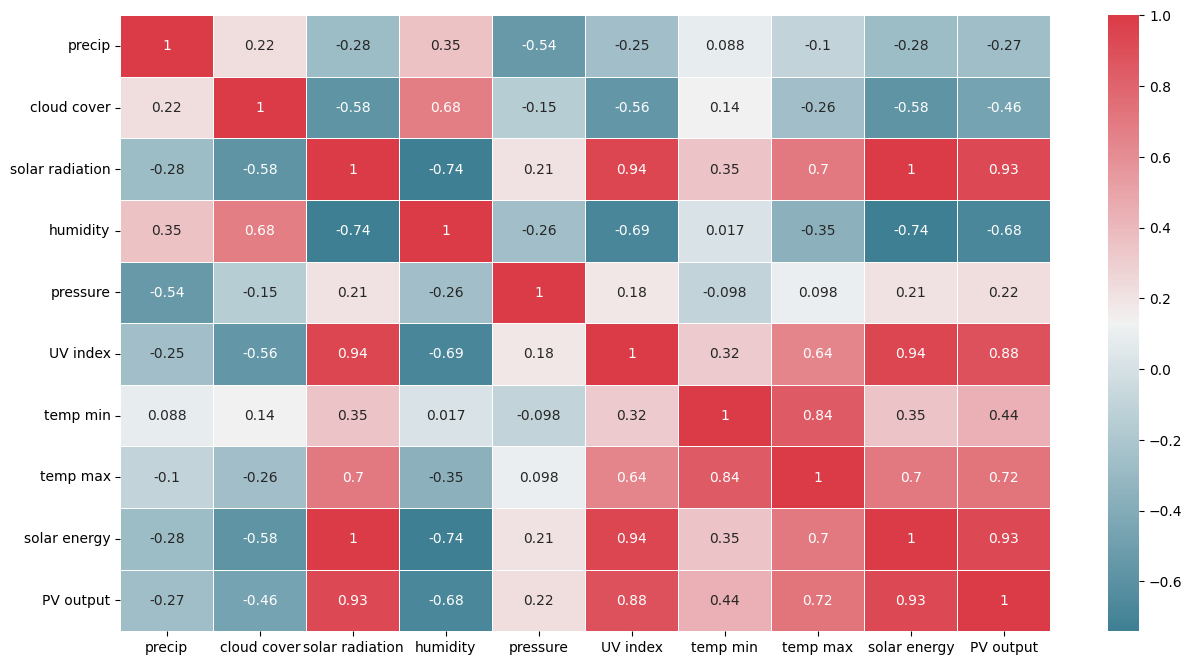

In [17]:
def correlation_matrix(df_temporary):
    fig, ax = plt.subplots(figsize= (15, 8))
    df_corr = df_temporary.corr()
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(df_corr, annot=True, cmap=cmap, linewidths= 0.7)
    plt.show()
correlation_matrix(df_temporary)

In [18]:
df_final = pd.concat([df_date, df_temporary], axis = 1)
df_final

,date,precip,cloud cover,solar radiation,humidity,pressure,UV index,temp min,temp max,solar energy,PV output
0,2019-12-01,0.000,72.0,27.90,87.3,1024.4,2.0,0.9,5.4,2.4,0.748
1,2019-12-02,0.120,41.2,52.58,82.0,1032.6,2.0,-1.1,5.8,3.9,1.122
2,2019-12-03,0.000,59.8,42.50,82.6,1027.7,3.0,2.1,8.2,3.7,1.091
3,2019-12-04,0.096,26.2,43.80,90.6,1020.7,3.0,1.0,6.9,3.7,1.060
4,2019-12-05,0.134,85.2,26.50,91.5,1019.4,2.0,1.9,9.7,2.3,0.712
...,...,...,...,...,...,...,...,...,...,...,...
788,2022-01-27,0.605,64.0,23.60,91.7,1030.8,1.0,2.0,10.4,2.1,0.612
789,2022-01-28,0.191,61.8,40.80,95.9,1035.6,2.0,0.6,9.1,3.5,0.401
790,2022-01-29,1.226,77.8,31.00,93.5,1031.9,1.0,3.5,10.2,2.6,0.700
791,2022-01-30,0.124,38.8,53.90,88.9,1031.4,3.0,0.4,8.0,4.7,1.313


In [19]:
df_final

,date,precip,cloud cover,solar radiation,humidity,pressure,UV index,temp min,temp max,solar energy,PV output
0,2019-12-01,0.000,72.0,27.90,87.3,1024.4,2.0,0.9,5.4,2.4,0.748
1,2019-12-02,0.120,41.2,52.58,82.0,1032.6,2.0,-1.1,5.8,3.9,1.122
2,2019-12-03,0.000,59.8,42.50,82.6,1027.7,3.0,2.1,8.2,3.7,1.091
3,2019-12-04,0.096,26.2,43.80,90.6,1020.7,3.0,1.0,6.9,3.7,1.060
4,2019-12-05,0.134,85.2,26.50,91.5,1019.4,2.0,1.9,9.7,2.3,0.712
...,...,...,...,...,...,...,...,...,...,...,...
788,2022-01-27,0.605,64.0,23.60,91.7,1030.8,1.0,2.0,10.4,2.1,0.612
789,2022-01-28,0.191,61.8,40.80,95.9,1035.6,2.0,0.6,9.1,3.5,0.401
790,2022-01-29,1.226,77.8,31.00,93.5,1031.9,1.0,3.5,10.2,2.6,0.700
791,2022-01-30,0.124,38.8,53.90,88.9,1031.4,3.0,0.4,8.0,4.7,1.313


from this correlation matrix we can see easily that some variables have strong positiv correlations to pv output, some variables have moderate positive correlations and some have
Negative correlation to pv output.

**positive correlations**
solar radiation  vs pv output ---> (0.93) --> high solar radiation leads to higher pv output
solar energy vs pv output --> (0.93) --> more solar energy increass pv output
uv index vs pv output -->(0.88)  ---> higher uv index leads to higher pv output

**moderate positive correlations**
temp max vs pv output --> (0.72) --> warmer temprature relates to more pv output
humidity vs pv output --> (-0.68) --> high humidity negatively impacts pv output

**weak correlation**
precipitation vs pv output --> (-0.27)
pressure vs output --> (0.22)






### Normalisation and Split Dataset into Train and Test

In [20]:
df_final = df_final.sort_values(by='date')   #we want to be sure dataset is sorted by date
df_final

,date,precip,cloud cover,solar radiation,humidity,pressure,UV index,temp min,temp max,solar energy,PV output
0,2019-12-01,0.000,72.0,27.90,87.3,1024.4,2.0,0.9,5.4,2.4,0.748
1,2019-12-02,0.120,41.2,52.58,82.0,1032.6,2.0,-1.1,5.8,3.9,1.122
2,2019-12-03,0.000,59.8,42.50,82.6,1027.7,3.0,2.1,8.2,3.7,1.091
3,2019-12-04,0.096,26.2,43.80,90.6,1020.7,3.0,1.0,6.9,3.7,1.060
4,2019-12-05,0.134,85.2,26.50,91.5,1019.4,2.0,1.9,9.7,2.3,0.712
...,...,...,...,...,...,...,...,...,...,...,...
788,2022-01-27,0.605,64.0,23.60,91.7,1030.8,1.0,2.0,10.4,2.1,0.612
789,2022-01-28,0.191,61.8,40.80,95.9,1035.6,2.0,0.6,9.1,3.5,0.401
790,2022-01-29,1.226,77.8,31.00,93.5,1031.9,1.0,3.5,10.2,2.6,0.700
791,2022-01-30,0.124,38.8,53.90,88.9,1031.4,3.0,0.4,8.0,4.7,1.313


#### Define Split dates: the first two years for training and the last two month for testing

In [21]:


def split_dataset(df):

    end_date_for_train = df_final['date'].min() + pd.DateOffset(years=2)  # for train dataset we set the first 2 years
    start_date_for_test = df_final['date'].max() - pd.DateOffset(months=2)  # last 2 month for testing

    # now split the dataset based on this time period definition
    train_dataset = df_final[df_final['date'] < end_date_for_train].copy()
    test_dataset = df_final[df_final['date'] > start_date_for_test].copy()

    print(f'train dataset shape before droping date column:{train_dataset.shape}')
    print(f'test dataset shape before droping date column :{test_dataset.shape}')
    # print(test_dataset.head)


    #now we can drop 'date' column because  it is not used for our modeling and processing
    train_dataset.drop(columns=['date'], inplace=True)
    test_dataset.drop(columns=['date'], inplace=True)

    print(f'train datset shape after droping date column:{train_dataset.shape}')
    print(f'test datset shape after droping date column:{test_dataset.shape}')
    return train_dataset, test_dataset
train_dataset, test_dataset = split_dataset(df_final)




train dataset shape before droping date column:(731, 11)
test dataset shape before droping date column :(62, 11)
train datset shape after droping date column:(731, 10)
test datset shape after droping date column:(62, 10)


#### Define Features and Target Variables

In [72]:
def separate_features_from_target(train_dataset, test_dataset):
    X_train = train_dataset.drop(columns=['PV output'])
    y_train = train_dataset['PV output']
    X_test = test_dataset.drop(columns=['PV output'])
    y_test = test_dataset['PV output']
    print(f'X_train shape:{X_train.shape}')
    print(f'X_test shape:{X_test.shape}')
    print(f'y_train shape:{y_train.shape}')
    print(f'y_test shape:{y_test.shape}')
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = separate_features_from_target(train_dataset, test_dataset)
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

X_train shape:(731, 9)
X_test shape:(62, 9)
y_train shape:(731,)
y_test shape:(62,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Handling Outliers

In [73]:
def detect_outliers(X_train, y_train):
    """
    Apply Isolation forest to detect outliers in training dataset
    
    """
    iso_forest = IsolationForest(n_estimators=100, contamination = 0.05, random_state=42)
    outliers = iso_forest.fit_predict(X_train)

    outlier_counts = pd.Series(outliers).value_counts()
    number_of_outliers = outlier_counts.get(-1, 0)  #get count of -1 (outliers)
    number_of_inliers = outlier_counts.get(1, 0)    # get count of 1 (inliers)

    print(f'number of outliers:{number_of_outliers}')
    print(f'number of inliers:{number_of_inliers}')

    total_data_points = len(X_train)
    outliers_percentage = (number_of_outliers / total_data_points) * 100
    print(f'outliers percentage in whole dataset is: {outliers_percentage}')


detect_outliers(X_train, y_train)



    

number of outliers:37
number of inliers:694
outliers percentage in whole dataset is: 5.06155950752394


Since only 5% of dataset are outliers, we can remove them without losing too much information 

### Visualise outliers before and after handling with QQ Plot

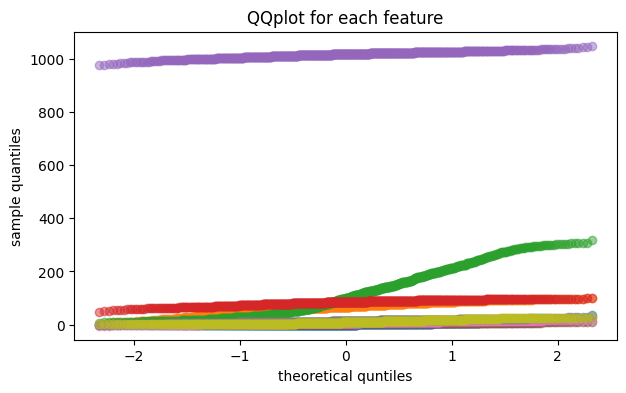

 shape of X_train after removing outliers:(694, 9)
 shape of y_train after removing outliers:(694,)


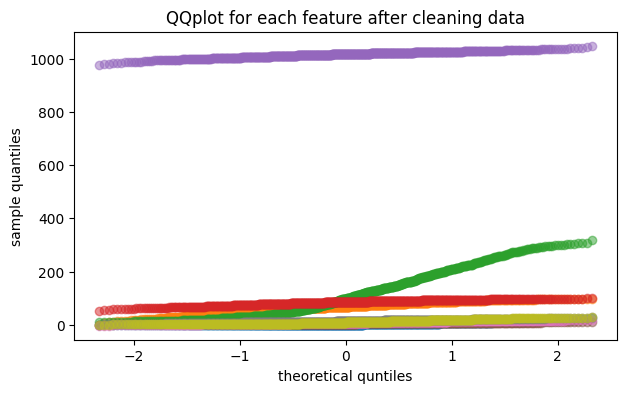

(694, 9)
(694,)


In [74]:
def visualise_handle_outliers(X_train, y_train):

    iso_forest = IsolationForest(n_estimators=100, contamination = 0.05, random_state=42)
    outliers = iso_forest.fit_predict(X_train)



    # visualise outliers before handling them
    plt.figure(figsize=(7, 4))
    for column in X_train.columns:
        sorted_values = np.sort(X_train[column])
        theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_values)))
        plt.scatter(theoretical_quantiles, sorted_values, alpha=0.5)
    plt.title('QQplot for each feature')
    plt.xlabel('theoretical quntiles')
    plt.ylabel('sample quantiles')
    plt.grid(False)
    plt.show()

    X_train['outlier'] = outliers
    X_train_cleaned = X_train[X_train['outlier']==1].drop(columns=['outlier'])
    X_train_with_no_outliers_index = X_train_cleaned.index

    y_train_cleaned = y_train.loc[X_train_with_no_outliers_index]

    print(f' shape of X_train after removing outliers:{X_train_cleaned.shape}')
    print(f' shape of y_train after removing outliers:{y_train_cleaned.shape}')


    #Now visualize QQplot after handling outliers
    plt.figure(figsize=(7, 4))
    for column in X_train_cleaned.columns:
        sorted_values = np.sort(X_train_cleaned[column])
        theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_values)))
        plt.scatter(theoretical_quantiles, sorted_values, alpha=0.5)
    plt.title('QQplot for each feature after cleaning data')
    plt.xlabel('theoretical quntiles')
    plt.ylabel('sample quantiles')
    plt.grid(False)
    plt.show()

    return X_train_cleaned, y_train_cleaned
    # remove outliers from our trining dataset
X_train_cleaned, y_train_cleaned = visualise_handle_outliers(X_train, y_train)
print(X_train_cleaned.shape)
print(y_train_cleaned.shape)



after removing outliers we see more consistent pattern in our train dataset. 

### Normalising the Train Dataset

In [76]:
def Normalize_data(X_train, y_train, X_test, y_test):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # scaler fit_transform on train set
    X_test_scaled = scaler.transform(X_test)        # scaler only transform on test set to avoid data leaking

    df_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)  #convert X_train_scaled to dataframe
    df_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)      ##convert X_train_scaled to dataframe

    # y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())
    # y_test = (y_test - y_test.min()) / (y_test.max() - y_test.min())

    return df_train_scaled, df_test_scaled, y_train, y_test

X_train_scaled, X_test_scaled, y_train, y_test = Normalize_data(X_train_cleaned, y_train_cleaned, X_test, y_test) 


print(f'X_train_scaled shape:{X_train_scaled.shape}')
print(f'X_test_scaled shape:{X_test_scaled.shape}')
print(f'y_train shape:{y_train.shape}')
print(f'y_test shape:{y_test.shape}')

X_train_scaled shape:(694, 9)
X_test_scaled shape:(62, 9)
y_train shape:(694,)
y_test shape:(62,)


#### Calculating VIF score to identify Multicollinearity

Variance Inflation Factor(VIF) is a statistical measure which can detect multicollinearity between independent variables(Sundus et al., 2022)
Sundus, K.I., Hammo, B.H., Al-Zoubi, M.B. and Al-Omari, A., 2022. Solving the multicollinearity problem to improve the stability of machine learning algorithms applied to a 
fully annotated breast cancer dataset. Informatics in Medicine Unlocked, 33, p.101088.

from this paper, we decided to handle the multicollinearity problem which is when two or more features are highly correlated to each other. when one feature has high correlation with other feature, this means one of these features are enough in
our calculations and modeling and that feature can iterpret and predict the output itself. we can simply remove one feature. otherwise this can have negative effect on our prediction.

from correlation matrix we can see two variable **solar radiation** and **solar energy** has correlation of 1 which means 100% they can describe each other so one of them should be removed.
between these two, we look at correlation of each with **pv output** , whichever have high correlation with output that would be selected.

for better understanding the relationship and correlation between independent variables we only need to calculate VIF score



In [77]:
%pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
#function to calculate VIF score  for X_train_scaled

def calculate_vif(X):
    # create a dataframe to store vif scores
    vif_data = pd.DataFrame()
    vif_data['features'] = X.columns
    #calculate vif score for each features
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

vif_scores = calculate_vif(X_train_scaled)
print(f'vif scores are:{vif_scores}')
vif_scores


Note: you may need to restart the kernel to use updated packages.
vif scores are:          features         VIF
0           precip    1.597353
1      cloud cover    2.282771
2  solar radiation  825.967610
3         humidity    2.970669
4         pressure    1.571957
5         UV index    8.599232
6         temp min    7.133647
7         temp max    9.471909
8     solar energy  842.810478



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Zohre\Desktop\danucore\myenv\Scripts\python.exe -m pip install --upgrade pip


,features,VIF
0,precip,1.597353
1,cloud cover,2.282771
2,solar radiation,825.967610
3,humidity,2.970669
4,pressure,1.571957
5,UV index,8.599232
6,temp min,7.133647
7,temp max,9.471909
8,solar energy,842.810478


#### X_train_scaled, X_test_scaled, y_train, y_test

In [78]:
print(f'X_train_scaled :\n\n{X_train_scaled}')
print(f'X_test_scaled :\n\n{X_test_scaled}')
print(f'y_train:\n\n{y_train}')
print(f'y_test:\n\n{y_test}')

X_train_scaled :

       precip  cloud cover  solar radiation  humidity  pressure  UV index  \
0   -0.624943     0.295776        -1.045867  0.409504  0.827314 -0.925894   
1   -0.593542    -1.309389        -0.740148 -0.174241  1.590714 -0.925894   
2   -0.624943    -0.340036        -0.865012 -0.108157  1.134536 -0.509722   
3   -0.599822    -2.091125        -0.848909  0.772968  0.482853 -0.509722   
4   -0.589878     0.983703        -1.063210  0.872095  0.361826 -0.925894   
..        ...          ...              ...       ...       ...       ...   
689  0.215841    -0.256651        -1.016138  0.200237 -1.416337 -0.925894   
690 -0.267486    -0.001284        -1.140011 -2.134744 -1.369788 -0.925894   
691 -0.619710    -0.543288        -0.873684 -1.297676 -0.559840 -0.509722   
692 -0.545915     0.671009        -1.094674  0.387476  0.054604 -0.925894   
693 -0.513729     1.233859        -1.074358  1.081362 -0.261927 -0.925894   

     temp min  temp max  solar energy  
0   -1.421353 -1.

### Feature Selection using correlation


as we can see precip (1.59), cloud cover(2.28), humidity (2.97) pressure (1.57) dont show strong multicollinearity.
uv index (8.5), temp min(7.13), temp max (9.47) show moderate multicollinearity.
solar radiation (825.96) and solar energy (842.81) show very high multicollinearity. meaning these two feature are highly correlated and keeping both in model can cause instability.



from correlation matrix and vif score we can remove solar energy because it already includes solar radiation indirectly.keeping both can make our model unstable.
since temp min and temp max have multicollinearity and one of them are enough to describe the other , we drop one of them. in addition, uv index also has 0.93 correlation with solar energy and solar radiation.
so it would be sensible to drop uv index from our calculation.
from correlation we select 6 features out of nine.


basd on this **paper** :
**Fan, Y., Liu, J., Tang, J., Liu, P., Lin, Y. and Du, Y., 2024. Learning correlation information for multi-label feature selection. Pattern Recognition, 145, p.109899.**
one method for feature selection is feature selection based on correlation . in this method we measure correlation between independent variabled with each other. if two features have high correlation like solar energy and solar radiation one have to be discarded, because one already can describe the other .we dont need both of them.otherwise this can have negative effect on our modeling process.make our model unstable.


### 1- Feature Selection with Correlation (threshold=0.75)

In [ ]:
def correlation_feature_selection(X_train, X_test, threshold = 0.85):

    corr_matrix = X_train.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    #dropp features with high correlation 
    features_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    print(f'features_to_drop:{features_to_drop}')
    X_train_corr = X_train.drop(columns=features_to_drop)
    X_test_corr = X_test.drop(columns=features_to_drop)

    return X_train_corr, X_test_corr

X_train_corr, X_test_corr = correlation_feature_selection(X_train_scaled.copy(), X_test_scaled.copy())

print(f'X_train_scaled shape:\n{X_train_scaled.shape}')
print(f'X_test_scaled shape:\n{X_test_scaled.shape}')
# print(f'X train_scaled:\n{X_train_scaled}')
# print(f'X_test_scaled:\n{X_test_scaled}')

print(f'X_train_corr :\n\n{X_train_corr}')
print(f'X_test_corr :\n\n{X_test_corr}')

features_to_drop:['humidity', 'UV index', 'temp max', 'solar energy']
X_train_scaled shape:
(694, 9)
X_test_scaled shape:
(62, 9)
X_train_corr :

       precip  cloud cover  solar radiation  pressure  temp min
0   -0.624943     0.295776        -1.045867  0.827314 -1.421353
1   -0.593542    -1.309389        -0.740148  1.590714 -1.870297
2   -0.624943    -0.340036        -0.865012  1.134536 -1.151987
3   -0.599822    -2.091125        -0.848909  0.482853 -1.398906
4   -0.589878     0.983703        -1.063210  0.361826 -1.196881
..        ...          ...              ...       ...       ...
689  0.215841    -0.256651        -1.016138 -1.416337 -1.039751
690 -0.267486    -0.001284        -1.140011 -1.369788 -1.219328
691 -0.619710    -0.543288        -0.873684 -0.559840 -1.421353
692 -0.545915     0.671009        -1.094674  0.054604 -1.847849
693 -0.513729     1.233859        -1.074358 -0.261927 -0.096969

[694 rows x 5 columns]
X_test_corr :

      precip  cloud cover  solar radiation  pre

### Feature selection with Mutual Information 

In [142]:
#define function for mutual information feature selection
def mutual_info_feature_selection(X_train, y_train, X_test, k= 5):


    feature_selector = SelectKBest(score_func=mutual_info_regression, k=k)  #initialise SelectKBest with mutual information

    feature_selector.fit(X_train, y_train)                                  # fit feature selector to training data

    selected_features = list(X_train.columns[feature_selector.get_support()])

    
    feature_scores = pd.Series(feature_selector.scores_, index=X_train.columns).sort_values(ascending=False) #get score for feature importance

    X_train_fs = pd.DataFrame(feature_selector.transform(X_train), columns=selected_features, index=X_train.index) #transform train and test data to have only selected features
    X_test_fs = pd.DataFrame(feature_selector.transform(X_test), columns=selected_features, index=X_test.index)
    # print(f'selected features :{selected_features}')
    # print(f'feature_scores :{feature_scores}')




    return X_train_fs, X_test_fs


X_train_mu_info, X_test_mu_info = mutual_info_feature_selection(X_train_scaled.copy(), y_train.copy(), X_test_scaled.copy(), k=6)

print(f'X_train_mu_info:\n\n{X_train_mu_info}\n')
print(f'X_test_mu_info:\n\n{X_test_mu_info}')
print(f'selecte_mu_info_features:\n\n{selecte_mu_info_features}')
print(f'mu_info_scores:\n\n{mu_info_scores}\n')
print(type(X_train_mu_info))








X_train_mu_info:

     cloud cover  solar radiation  humidity  UV index  temp max  solar energy
0       0.295776        -1.045867  0.409504 -0.925894 -1.596540     -1.044784
1      -1.309389        -0.740148 -0.174241 -0.925894 -1.517247     -0.829920
2      -0.340036        -0.865012 -0.108157 -0.509722 -1.041490     -0.858569
3      -2.091125        -0.848909  0.772968 -0.509722 -1.299192     -0.858569
4       0.983703        -1.063210  0.872095 -0.925894 -0.744142     -1.059108
..           ...              ...       ...       ...       ...           ...
689    -0.256651        -1.016138  0.200237 -0.925894 -0.962197     -1.016136
690    -0.001284        -1.140011 -2.134744 -0.925894 -1.656009     -1.130730
691    -0.543288        -0.873684 -1.297676 -0.509722 -1.418131     -0.872893
692     0.671009        -1.094674  0.387476 -0.925894 -1.477600     -1.030460
693     1.233859        -1.074358  1.081362 -0.925894 -0.545910     -1.059108

[694 rows x 6 columns]

X_test_mu_info:

    

### Feature Selection with PCA

In [ ]:
def pca_feature_selection(X_train, X_test, variance_threshold=0.80):

    pca = PCA()   # initialise pca

    X_train_pca = pca.fit_transform(X_train)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # now we need to find the minimum number of components to reach the variance threshols
    n_components = np.argmax(explained_variance >= variance_threshold) + 1
    print(f'pca selected {n_components} that can explain {variance_threshold} * 100')

    # now we apply pca with the best number of components
    pca = PCA(n_components=n_components)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    pca_columns = [f"pc{i+1}" for i in range(n_components)]

    X_train_pca_df = pd.DataFrame(X_train_reduced, index=X_train.index, columns=pca_columns)
    X_test_pca_df = pd.DataFrame(X_test_reduced, index=X_test.index, columns=pca_columns)


    return X_train_pca_df, X_test_pca_df

X_train_pca, X_test_pca = pca_feature_selection(X_train_scaled.copy(), X_test_scaled.copy(), variance_threshold=0.80)

print(f'shape of X_train_pca:{X_train_pca.shape}')
print(f'shape of X_test_pca:{X_test_pca.shape}')
print(f'number of components:{n_components_pca}')
# print(type(X_train_pca))
# print(type(X_test_pca))






pca selected 3 that can explain 0.8 * 100
shape of X_train_pca:(694, 3)
shape of X_test_pca:(62, 3)
number of components:5
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


since this is regression problem it is good to practice Histogram or kde plot to check distribution of target variables:


 mean of PV output:2.9513
 median of PV output:2.7585
standard deviation:2.0028
min value of PV output:0.0780, max value:6.8700


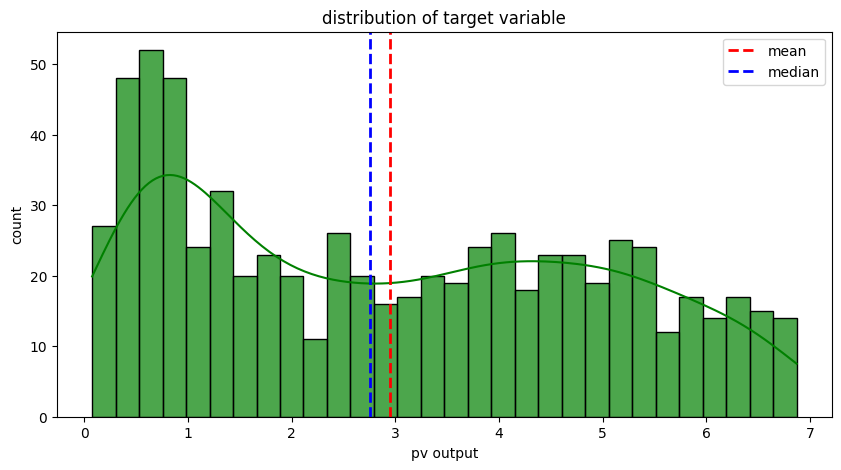

In [158]:
def check_target_distribution(y_train):
    """ 
    we want to check distibution of target variable in regression problem. for this we utilze statistics and visualization

    """
    #first we check some basic statistics
    print(f' mean of PV output:{y_train.mean():.4f}')
    print(f' median of PV output:{y_train.median():.4f}')
    print(f'standard deviation:{y_train.std():.4f}')
    print(f'min value of PV output:{y_train.min():.4f}, max value:{y_train.max():.4f}')

    #plot histogram and kde plot to visualise the distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(y_train, bins=30, kde=True, color='green', alpha=0.7)
    plt.axvline(y_train.mean(), color='red', linestyle='dashed', linewidth=2, label='mean')
    plt.axvline(y_train.median(), color='blue', linestyle='dashed', linewidth=2, label='median')
    plt.legend()
    plt.title('distribution of target variable')
    plt.xlabel('pv output')
    plt.ylabel('count')
    plt.show()

check_target_distribution(y_train)

In [ ]:
this graph shows multimodal distribution because there is more than one peak, which means the data influences by different conditions.

## Building Models

In [179]:
def train_evaluate_grid_search(X_train, X_test, y_train, y_test, feature_selection_method):
    models={

        "Decision Tree": DecisionTreeRegressor(),
        "RandomForest": RandomForestRegressor(),
        "KNN Regressor":KNeighborsRegressor(),
        "AdaBoost": AdaBoostRegressor(),
        "XGBoost":XGBRegressor(),
        # "Ridg Regression":Ridge(),
        # "LassoRegression": Lasso(),
        "Linear Regression":LinearRegression(),
        
    }

    param_grid = {

        "Ridge Regression": {"alpha":[0.1, 1, 10]},
        "Lasso Regression": {"alpha":[0.1, 1, 10]},
        "Decision Tree": {"max_depth":[10, 20]},
        "RandomForest":{"n_estimators":[50, 100], "max_depth":[10, 20]},
        "KNN Regressor":{"n_neighbors":[10]},
        "AdaBoost":{"n_estimators":[50, 100]},
        "XGBoost":{"n_estimators":[50, 100], "learning_rate":[0.01, 0.1]},
        "Linear Regression":{}
    }

    results = {}

    for name, model in models.items():
        grid_search = GridSearchCV(model, param_grid.get(name, {}), cv=5, scoring="r2", verbose=0)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        r2 = r2_score(y_test, y_pred)
        r2_train = r2_score(y_train, y_pred_train)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results[name] = {"R2 score": r2, "MAE": mae, "RMSE":rmse, "ro_score_train":r2_train }
        print(f"best parameteres {name}: {grid_search.best_params_}")
    return pd.DataFrame(results).T

all_results = {}   


#feature selection with correlation
X_train_corr, X_test_corr = correlation_feature_selection(X_train_scaled.copy(), X_test_scaled.copy(), threshold=0.75) 
results_with_corr = train_evaluate_grid_search(X_train_corr, X_test_corr, y_train, y_test, "correlation_based feature selection")
all_results["correlation"] = results_with_corr

# #feature selection with mutual information
X_train_mu_info, X_test_mu_info = mutual_info_feature_selection(X_train_scaled.copy(), y_train, X_test_scaled.copy(), k=5)
results_with_mi = train_evaluate_grid_search(X_train_mu_info, X_test_mu_info, y_train, y_test, "mutual information feature selection")
all_results["mutual information"] = results_with_mi


# #feature selection with PCA
X_train_pca, X_test_pca = pca_feature_selection(X_train_scaled.copy(), X_test_scaled.copy(), variance_threshold=0.95)
results_with_pca =  train_evaluate_grid_search(X_train_pca, X_test_pca, y_train, y_test, "pca feature selection") 
all_results["PCA"] = results_with_pca





final_results = pd.concat(all_results, axis=1)
print(f'final results\n\n:{final_results}')




    
    


features_to_drop:['UV index', 'temp max', 'solar energy']
best parameteres Decision Tree: {'max_depth': 10}
best parameteres RandomForest: {'max_depth': 20, 'n_estimators': 100}
best parameteres KNN Regressor: {'n_neighbors': 10}
best parameteres AdaBoost: {'n_estimators': 50}
best parameteres XGBoost: {'learning_rate': 0.1, 'n_estimators': 50}
best parameteres Linear Regression: {}
best parameteres Decision Tree: {'max_depth': 20}
best parameteres RandomForest: {'max_depth': 20, 'n_estimators': 50}
best parameteres KNN Regressor: {'n_neighbors': 10}
best parameteres AdaBoost: {'n_estimators': 50}
best parameteres XGBoost: {'learning_rate': 0.1, 'n_estimators': 50}
best parameteres Linear Regression: {}
pca selected 5 that can explain 0.95 * 100
best parameteres Decision Tree: {'max_depth': 20}
best parameteres RandomForest: {'max_depth': 10, 'n_estimators': 100}
best parameteres KNN Regressor: {'n_neighbors': 10}
best parameteres AdaBoost: {'n_estimators': 100}
best parameteres XGBoos

### Build CNN-LSTM Model

In [187]:
import numpy as np
%pip install tensorflow 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import cONV1d, MaxPooling1D, Flatten, RepeatVector, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam 
from sklearn.preprocessing import MinMaxScaler 

def preprocess_for_cnn_lstm(X_train, X_test, y_train, y_test):
    #first we need to convert dataframe to numpy array
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy() 


    y_train_np = y_train.to_numpy().reshape(-1, 1)
    y_test_np = y_test.to_numpy().reshape(-1, 1)

    #now reshape xtrain and xtest to 3D for cnn-lstm (samples, time steps, features)
    X_train_reshaped = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
    X_test_reshaped = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))
    return X_train_reshaped, X_test_reshaped, y_train_np, y_test_np


X_train_cnnlstm, X_test_cnnlstm, y_train_cnnlstm, y_test_cnnlstm = preprocess_for_cnn_lstm(X_train_scaled.copy(), X_test_scaled.copy(), y_train, y_test)

def build_cnn_lstm(input_shape):
    model = Sequential([

        
        Conv1D(filters=16, kernel_size=3, activation='relu', padding='same', input_shape = input_shape),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Flatten(),

        #LSTM
        RepeatVector(1),
        LSTM(16, activation = 'relu', return_sequences=True),
        LSTM(32, activation='relu', return_sequences=True),
        LSTM(64, activation='relu', return_sequences=True),


        TimeDistributed(Dense(100, activation='relu')),
        TimeDistributed(Dense(1)),
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model



input_shape = (X_train_cnnlstm.shape[1], X_train_cnnlstm.shape[2])
cnn_lstm_model = build_cnn_lstm(input_shape)

cnn_lstm_model.summary()

#train the model
history = cnn_lstm_model.fit(X_train_cnnlstm, y_train_cnnlstm,
                                
                            validation_data=(X_test_cnnlstm, y_test_cnnlstm),
                            epochs=30, batch_size=32, verbose=1)

#evaluate model
loss, mae = cnn_lstm_model.evaluate(X_test_cnnlstm, y_test_cnnlstm)
print(f"test loss:{loss:.4f}, test MAE:{mae:.4f}")
























Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Zohre\Desktop\danucore\myenv\Scripts\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# def train_evaluate_predict(X_train, X_test, y_train, y_test, model_name):
#     models={

#         "Decision Tree": DecisionTreeRegressor(),
#         "RandomForest": RandomForestRegressor(),
#         "KNN Regressor":KNeighborsRegressor(),
#         "AdaBoost": AdaBoostRegressor(),
#         "XGBoost":XGBRegressor()
#     }

    

#     results={}
#     for name, model in models.items():

#         model.fit(X_train, y_train)
#         y_pred_train = model.predict(X_train)
#         y_pred = model.predict(X_test)
        
       
#         r2_train = r2_score(y_train, y_pred_train)
#         r2 = r2_score(y_test, y_pred)
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         results[name] = {"R2 score": r2, "MAE": mae, "RMSE":rmse, "ro_score_train":r2_train }

        
#     return pd.DataFrame(results).T


In [ ]:
# #feature selection with correlation
# # X_train_corr, X_test_corr = correlation_feature_selection(X_train_scaled.copy(), X_test_scaled.copy()) 
# # results_with_corr = train_evaluate_predict(X_train_corr, X_test_corr, y_train, y_test, "correlation_based feature selection")

# # #feature selection with mutual information
# X_train_mu_info, X_test_mu_info = mutual_info_feature_selection(X_train_scaled.copy(), y_train, X_test_scaled.copy(), k=6)
# results_with_mi = train_evaluate_predict(X_train_mu_info, X_test_mu_info, y_train, y_test, "mutual information feature selection")

# # #feature selection with PCA
# # X_train_pca, X_test_pca = pca_feature_selection(X_train_scaled.copy(), X_test_scaled.copy(), variance_threshold=0.95)
# # print(type(X_train_pca))
# # print(type(y_train))
# # results_with_pca =  train_evaluate_predict(X_train_pca, X_test_pca, y_train, y_test, "pca feature selection") 

# all_results = {

#     # "correlation_based": results_with_corr,
#     "mutual information": results_with_mi,
#     # "PCA":results_with_pca
# }


# final_results = pd.concat(all_results, axis=1)
# print(f'final results\n\n:{final_results}')


final results

:              mutual information                                   
                        R2 score       MAE      RMSE ro_score_train
Decision Tree          -0.105391  0.295935  0.374615       1.000000
RandomForest            0.401831  0.215681  0.275574       0.984971
KNN Regressor           0.470182  0.209794  0.259352       0.921574
AdaBoost               -0.420001  0.362671  0.424591       0.907611
XGBoost                 0.269382  0.250596  0.304559       0.999690


## Q2 - Extracting data using LLMs

The accompanying PDF file is a data sheet that gives specifications for a number of hardware products available from GivEnergy. Use an open source Large Language Model of your choice to run inference optimally on a single or multi-node cluster to extract the data from this pdf to the best of its ability. Please provide a record of the prompts you use in your interaction with the LLM.



In [ ]:
import pandas as pd